## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import time
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist is created!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



In [4]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [5]:
len(fmnist_dataset_test)

10000

### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [6]:
from torch.nn.modules.batchnorm import BatchNorm1d
from torch.nn.modules.dropout import Dropout
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, input_shape // 2),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(input_shape // 2, input_shape // 4),
            nn.BatchNorm1d(input_shape // 4)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [7]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 392]         307,720
              ReLU-3                  [-1, 392]               0
           Dropout-4                  [-1, 392]               0
            Linear-5                  [-1, 196]          77,028
       BatchNorm1d-6                  [-1, 196]             392
Total params: 385,140
Trainable params: 385,140
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.47
Estimated Total Size (MB): 1.49
----------------------------------------------------------------


Your experiments come here:

In [8]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()

# Your experiments, training and validation loops here

def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs: int):
    train_loss_history = []
    val_loss_history = []
    train_accuracy_history = []
    val_accuracy_history = []
    message = ''
    for i in range(n_epochs):
        
        start = time.time()
        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            # move data to target device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            y_pred = model(X_batch)
            loss = loss_func(y_pred, y_batch)
            loss.backward()
            opt.step()
            opt.zero_grad()

            y_pred = torch.argmax(y_pred, axis=1)
            train_accuracy_history.append(torch.sum(y_pred==y_batch).item() / len(y_batch))
            train_loss_history.append(loss.item())

        model.train(False) # disable dropout / use averages for batch_norm
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                # move data to target device
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                # compute predictions
                y_pred = model(X_batch)
                loss = loss_func(y_pred, y_batch)
                val_loss_history.append(loss.item())
                y_pred = torch.argmax(y_pred, axis=1)
                val_accuracy_history.append(torch.sum(y_pred==y_batch).item() / len(y_batch))
        end = time.time()
        message += f'Epoch num: {i} || Avg val loss: {round(sum(val_loss_history)/len(val_loss_history), 3)} || Avg train loss: {round(sum(train_loss_history)/len(train_loss_history), 3)} || Time needed: {round(end-start, 3)} sec.\n'  

        clear_output(wait=True)
        plt.figure(figsize=(16, 10))
        fig, axs = plt.subplots(2, 2)
        fig.set_size_inches(16, 10)
        axs[0, 0].plot(val_loss_history, 'b', label='Validation' )
        axs[0, 0].set_title('Loss Validation')
        axs[0, 0].set(xlabel="#iteration", ylabel='loss', ylim=(0, 6))
        axs[0, 1].plot(train_loss_history, 'orange', label='Train' )
        axs[0, 1].set_title('Loss Train')
        axs[0, 1].set(xlabel="#iteration", ylabel='loss', ylim=(0, 6))
        axs[1, 0].plot(val_accuracy_history, 'g', label='Validation' )
        axs[1, 0].set_title('Accuracy Validation')
        axs[1, 0].set(xlabel="#iteration", ylabel='accuracy', ylim=(0, 1))
        axs[1, 1].plot(train_accuracy_history, 'r', label='Train')
        axs[1, 1].set_title('Accuracy Train')
        axs[1, 1].set(xlabel="#iteration", ylabel='accuracy', ylim=(0, 1))

        plt.show()
        
        print(message) 

    return train_loss_history, val_loss_history, val_accuracy_history, train_accuracy_history

<Figure size 1152x720 with 0 Axes>

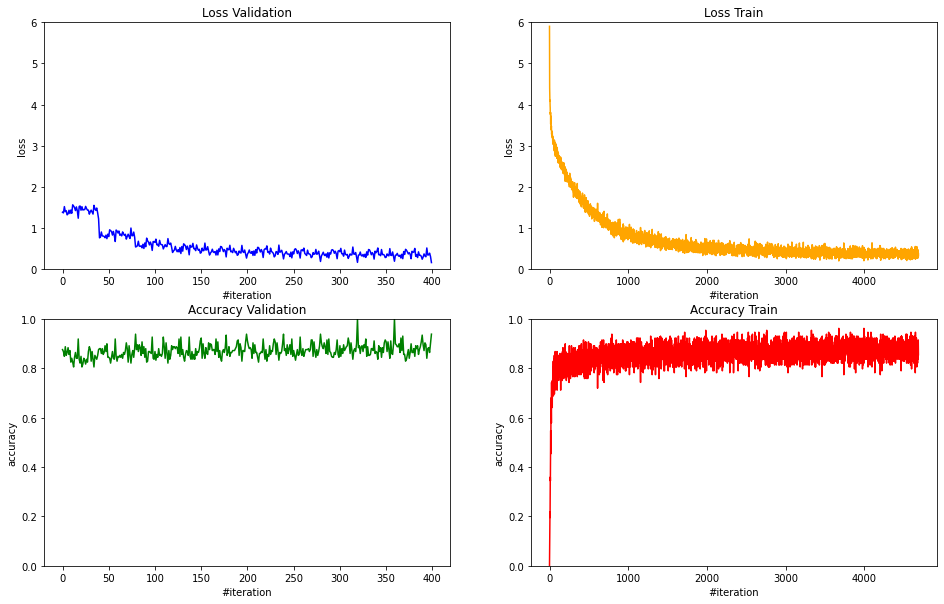

Epoch num: 0 || Avg val loss: 1.431 || Avg train loss: 2.323 || Time needed: 7.081 sec.
Epoch num: 1 || Avg val loss: 1.132 || Avg train loss: 1.746 || Time needed: 7.227 sec.
Epoch num: 2 || Avg val loss: 0.955 || Avg train loss: 1.416 || Time needed: 7.484 sec.
Epoch num: 3 || Avg val loss: 0.84 || Avg train loss: 1.209 || Time needed: 7.13 sec.
Epoch num: 4 || Avg val loss: 0.759 || Avg train loss: 1.067 || Time needed: 7.187 sec.
Epoch num: 5 || Avg val loss: 0.703 || Avg train loss: 0.965 || Time needed: 7.41 sec.
Epoch num: 6 || Avg val loss: 0.658 || Avg train loss: 0.887 || Time needed: 7.091 sec.
Epoch num: 7 || Avg val loss: 0.623 || Avg train loss: 0.826 || Time needed: 7.117 sec.
Epoch num: 8 || Avg val loss: 0.594 || Avg train loss: 0.776 || Time needed: 7.173 sec.
Epoch num: 9 || Avg val loss: 0.571 || Avg train loss: 0.735 || Time needed: 7.143 sec.



In [9]:
n_epochs = 10

train_loss, val_loss, val_accuracy, train_accuracy = train_model(model, train_loader, test_loader, loss_func, opt, n_epochs)

In [10]:
print(f'Accuracy on val: {val_accuracy[-1]}')

Accuracy on val: 0.9375


### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [19]:
indices = np.arange(20000)
train_dataset_decreased = torch.utils.data.Subset(fmnist_dataset_train, indices)
train_loader = torch.utils.data.DataLoader(train_dataset_decreased, 
                                           batch_size=256,
                                           shuffle=True,
                                           num_workers=2)

class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, input_shape * 2),
            nn.ReLU(),
            nn.Linear(input_shape * 2, input_shape * 8),
            nn.ReLU(),
            nn.Linear(input_shape * 8, input_shape * 2),
            nn.ReLU(),
            nn.Linear(input_shape * 2, input_shape),
            nn.ReLU(),
            nn.Linear(input_shape, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [20]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 1568]       1,230,880
              ReLU-3                 [-1, 1568]               0
            Linear-4                 [-1, 6272]       9,840,768
              ReLU-5                 [-1, 6272]               0
            Linear-6                 [-1, 1568]       9,836,064
              ReLU-7                 [-1, 1568]               0
            Linear-8                  [-1, 784]       1,230,096
              ReLU-9                  [-1, 784]               0
           Linear-10                   [-1, 10]           7,850
Total params: 22,145,658
Trainable params: 22,145,658
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.16
Params size (MB): 84.48
Esti

<Figure size 1152x720 with 0 Axes>

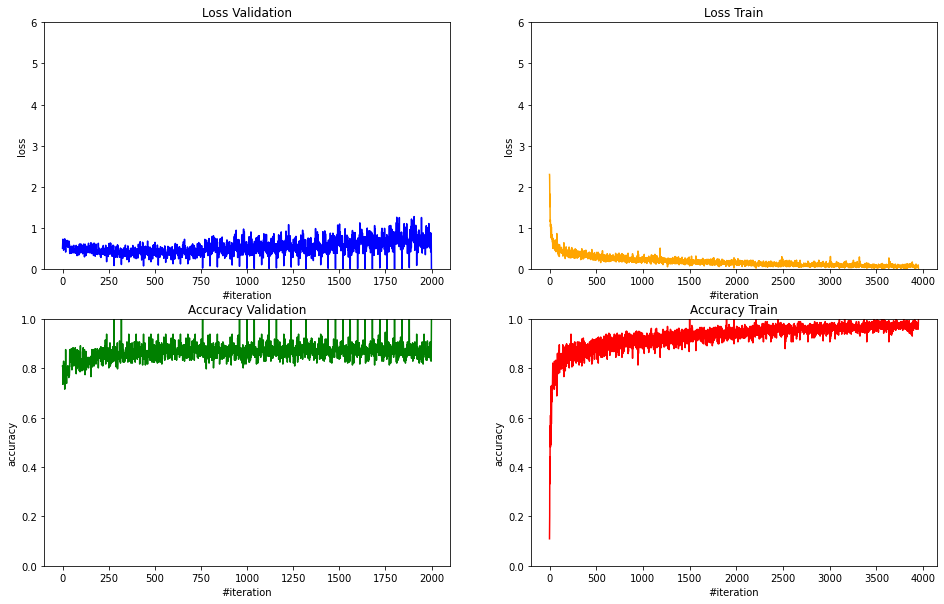

Epoch num: 0 || Avg val loss: 0.602 || Avg train loss: 0.793 || Time needed: 3.283 sec.
Epoch num: 1 || Avg val loss: 0.531 || Avg train loss: 0.625 || Time needed: 3.191 sec.
Epoch num: 2 || Avg val loss: 0.511 || Avg train loss: 0.548 || Time needed: 3.343 sec.
Epoch num: 3 || Avg val loss: 0.503 || Avg train loss: 0.503 || Time needed: 3.293 sec.
Epoch num: 4 || Avg val loss: 0.495 || Avg train loss: 0.473 || Time needed: 3.281 sec.
Epoch num: 5 || Avg val loss: 0.482 || Avg train loss: 0.448 || Time needed: 3.731 sec.
Epoch num: 6 || Avg val loss: 0.48 || Avg train loss: 0.427 || Time needed: 3.403 sec.
Epoch num: 7 || Avg val loss: 0.47 || Avg train loss: 0.41 || Time needed: 3.777 sec.
Epoch num: 8 || Avg val loss: 0.463 || Avg train loss: 0.394 || Time needed: 3.323 sec.
Epoch num: 9 || Avg val loss: 0.456 || Avg train loss: 0.381 || Time needed: 3.266 sec.
Epoch num: 10 || Avg val loss: 0.454 || Avg train loss: 0.369 || Time needed: 3.664 sec.
Epoch num: 11 || Avg val loss: 0.4

In [21]:
n_epochs = 50
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()

train_loss1, val_loss1, val_accuracy1, train_accuracy1 = train_model(model, train_loader, test_loader, loss_func, opt, n_epochs)

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [ ]:
#first get back to the original training dataset
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)

In [22]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Dropout(0.5),
            nn.Linear(input_shape, input_shape * 2),
            nn.ReLU(),
            nn.BatchNorm1d(input_shape * 2),
            nn.Linear(input_shape * 2, input_shape * 8),
            nn.Dropout(0.75),
            nn.ReLU(),
            nn.BatchNorm1d(input_shape * 8),
            nn.Linear(input_shape * 8, input_shape * 2),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.BatchNorm1d(input_shape * 2),
            nn.Linear(input_shape * 2, input_shape * 1),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(input_shape, num_classes),
            nn.BatchNorm1d(num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [23]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
           Dropout-2                  [-1, 784]               0
            Linear-3                 [-1, 1568]       1,230,880
              ReLU-4                 [-1, 1568]               0
       BatchNorm1d-5                 [-1, 1568]           3,136
            Linear-6                 [-1, 6272]       9,840,768
           Dropout-7                 [-1, 6272]               0
              ReLU-8                 [-1, 6272]               0
       BatchNorm1d-9                 [-1, 6272]          12,544
           Linear-10                 [-1, 1568]       9,836,064
          Dropout-11                 [-1, 1568]               0
             ReLU-12                 [-1, 1568]               0
      BatchNorm1d-13                 [-1, 1568]           3,136
           Linear-14                  [

<Figure size 1152x720 with 0 Axes>

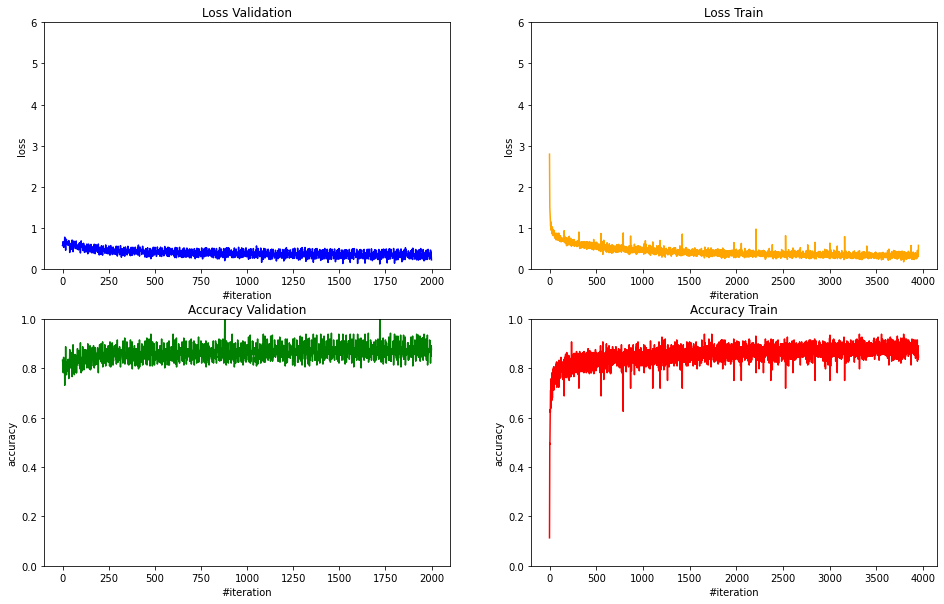

Epoch num: 0 || Avg val loss: 0.622 || Avg train loss: 0.981 || Time needed: 3.346 sec.
Epoch num: 1 || Avg val loss: 0.601 || Avg train loss: 0.865 || Time needed: 3.335 sec.
Epoch num: 2 || Avg val loss: 0.585 || Avg train loss: 0.801 || Time needed: 3.721 sec.
Epoch num: 3 || Avg val loss: 0.567 || Avg train loss: 0.759 || Time needed: 3.429 sec.
Epoch num: 4 || Avg val loss: 0.554 || Avg train loss: 0.726 || Time needed: 3.305 sec.
Epoch num: 5 || Avg val loss: 0.54 || Avg train loss: 0.7 || Time needed: 3.347 sec.
Epoch num: 6 || Avg val loss: 0.529 || Avg train loss: 0.679 || Time needed: 3.332 sec.
Epoch num: 7 || Avg val loss: 0.519 || Avg train loss: 0.66 || Time needed: 3.374 sec.
Epoch num: 8 || Avg val loss: 0.51 || Avg train loss: 0.642 || Time needed: 3.35 sec.
Epoch num: 9 || Avg val loss: 0.503 || Avg train loss: 0.628 || Time needed: 3.316 sec.
Epoch num: 10 || Avg val loss: 0.498 || Avg train loss: 0.615 || Time needed: 4.024 sec.
Epoch num: 11 || Avg val loss: 0.491 

In [24]:
n_epochs = 50
model = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()

train_loss_fixed, val_loss_fixed, val_accuracy_fixed, train_accuracy_fixed = train_model(model, train_loader, test_loader, loss_func, opt, n_epochs)

### Conclusions:
_Write down small report with your conclusions and your ideas._

In this lab work I was working with the Fashion-MNIST dataset, the work consisted of three tasks:
1. Train a simple neural network and gain the acccuracy of $\geq 0.885$

- I choose the simple one with Dropout and BacthNorm to prevent overffiting. It has $0.9375$ accuracy score and two linear layers
2. Intentionally overfit the network and so to say inspect the overfitting rate dependency on the model's complexity

- I found that after about 15 epoches OverfittingNeuralNetwork()'s loss was starting to increase.

3. Fix the overfitting.
- Dropout()'s and BatchNorm()'s were used to fix the most overfitted network OverfittingNeuralNetwork(). Having the put before and after each linear layer, I succeded at eliminating the overfitting in it.

*To sum it up, neural networks are eager to overfit and the simplier the model, faster it overfits. Dropout and Batch Normalization techniques are greate ways to prevent them from that.*
